<a href="https://colab.research.google.com/github/gestured/Style-Transfer-using-CNN/blob/main/StyleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from tensorflow.keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

#### Hyperparameters

In [ ]:
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68 , 116.779 , 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT= 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR= 1.25

In [ ]:
def get_images(input_path , style_path):
  input_image = Image.open(BytesIO(requests.get(input_path).content))
  input_image = input_image.resize((IMAGE_WIDTH , IMAGE_HEIGHT))
  input_image.save(input_image_path)
  # input_image

  style_image = Image.open(BytesIO(requests.get(style_path).content))
  style_image = style_image.resize((IMAGE_WIDTH , IMAGE_HEIGHT))
  style_image.save(style_image_path)
  # style_image

  #define input and style image arrays
  input_image_array = np.asarray(input_image , dtype="float32")
  input_image_array = np.expand_dims(input_image_array , axis=0)
  input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
  input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
  input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
  input_image_array = input_image_array[:, :, :, ::-1]

  style_image_array = np.asarray(style_image , dtype="float32")
  style_image_array = np.expand_dims(style_image_array , axis=0)
  style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
  style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
  style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
  style_image_array = style_image_array[:, :, :, ::-1]

  return input_image_array , style_image_array


def content_loss(content, combination):
  return backend.sum(backend.square(combination - content))


def gram_matrix(x):
  features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
  gram = backend.dot(features, backend.transpose(features))
  return gram


def compute_style_loss(style, combination):
  style = gram_matrix(style)
  combination = gram_matrix(combination)
  size = IMAGE_HEIGHT * IMAGE_WIDTH
  return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))


def total_variation_loss(x):
  a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
  b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
  return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))




def evaluate_loss_and_gradients(x):
  x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
  outs = backend.function([combination_image], outputs)([x])
  loss = outs[0]
  gradients = outs[1].flatten().astype("float64")
  return loss, gradients

class Evaluator:

  def loss(self, x):
    loss, gradients = evaluate_loss_and_gradients(x)
    self._gradients = gradients
    return loss

  def gradients(self, x):
    return self._gradients




Iteration 0 completed with loss 61467541504
Iteration 1 completed with loss 37615689728
Iteration 2 completed with loss 26272559104
Iteration 3 completed with loss 21850462208
Iteration 4 completed with loss 19577159680
Iteration 5 completed with loss 18009473024
Iteration 6 completed with loss 17067651072
Iteration 7 completed with loss 16379660288
Iteration 8 completed with loss 15888041984
Iteration 9 completed with loss 15520030720


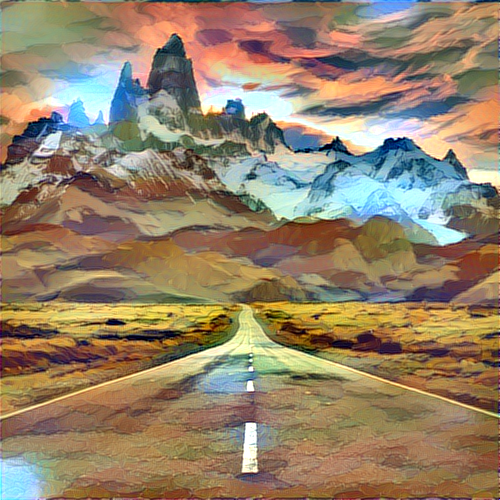

In [ ]:
input = "https://iso.500px.com/wp-content/uploads/2014/07/big-one.jpg"
style = "https://i.pinimg.com/736x/c5/eb/e8/c5ebe8da239d2bd22d97d57aaeba7046.jpg"
input_image_array , style_image_array = get_images(input , style)

input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1 , IMAGE_HEIGHT , IMAGE_SIZE , 3))

input_tensor = backend.concatenate([input_image , style_image , combination_image] , axis=0)

model = VGG16(input_tensor = input_tensor , include_top = False)


#Layers with features
layers = dict([(layer.name , layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss = loss + CONTENT_WEIGHT * content_loss(content_image_features , combination_features)


#Style Layers
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss = loss + (STYLE_WEIGHT / len(style_layers)) * style_loss


loss = loss + TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)



outputs = [loss]
outputs = outputs + backend.gradients(loss, combination_image)

evaluator = Evaluator()


x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

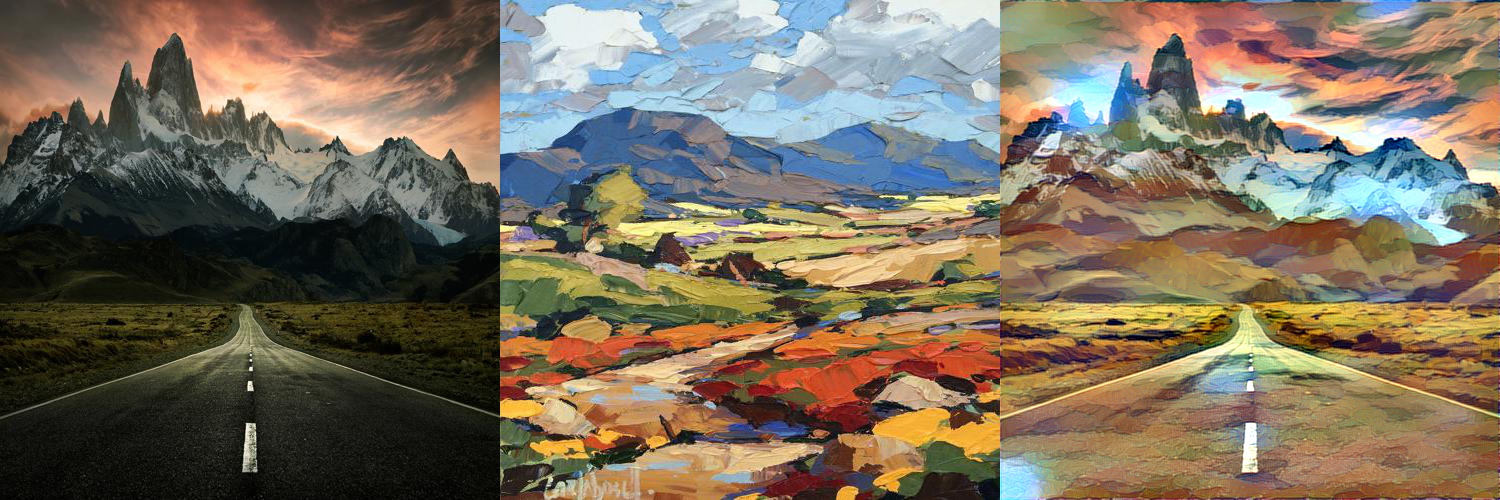

In [ ]:
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined